In [31]:
# Data import using Spark ML

from pyspark.sql import SQLContext
import pandas as pd
from pyspark.ml import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt

In [32]:
f = pd.read_csv("daily_weather.csv", sep=',', index_col=0)

# How many samples ?
f.shape

(1095, 10)

In [33]:
del f['relative_humidity_9am']

In [34]:
def functionG(row):
    if row['relative_humidity_3pm'] < 24.99999:
        val = 0
    else:
        val = 1
    return val

In [35]:
f['label'] = f.apply(functionG, axis=1)

#How many samples are in Class 1 (low humidity) ?
f['label'].sum()

547

# Hands On 1: Data Exploration

### Summary Statistics

In [36]:
f.describe()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_3pm,label
count,1092.000000,1090.000000,1091.000000,1092.000000,1092.000000,1091.000000,1089.000000,1092.000000,1095.000000,1095.000000
mean,918.882551,64.933001,142.235511,5.508284,148.953518,7.019514,0.203079,294.108052,35.344727,0.499543
std,3.184161,11.175514,69.137859,4.552813,67.238013,5.598209,1.593952,1598.078779,22.524079,0.500228
min,907.990000,36.752000,15.500000,0.693451,28.900000,1.185578,0.000000,0.000000,5.300000,0.000000
25%,916.550000,57.281000,65.972506,2.248768,76.553003,3.067477,0.000000,0.000000,17.395000,0.000000
50%,918.921045,65.715479,166.000000,3.871333,177.300000,4.943637,0.000000,0.000000,24.380000,0.000000
75%,921.160073,73.450974,191.000000,7.337163,201.233153,8.947760,0.000000,0.000000,52.060000,1.000000
max,929.320000,98.906000,343.400000,23.554978,312.200000,29.840780,24.020000,17704.000000,92.250000,1.000000


In [37]:
del f['relative_humidity_3pm']

In [38]:
f.columns[0:]

Index([u'air_pressure_9am', u'air_temp_9am', u'avg_wind_direction_9am',
       u'avg_wind_speed_9am', u'max_wind_direction_9am', u'max_wind_speed_9am',
       u'rain_accumulation_9am', u'rain_duration_9am', u'label'],
      dtype='object')

# Pairwise Correlation

In [39]:
# Pearson Correlation
f.corr(method='pearson')

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,label
air_pressure_9am,1.000000,-0.049252,-0.317073,0.235254,-0.293780,0.252614,-0.091142,-0.105059,-0.486934
air_temp_9am,-0.049252,1.000000,-0.024714,-0.286494,-0.088657,-0.283750,-0.214538,-0.266145,-0.267250
avg_wind_direction_9am,-0.317073,-0.024714,1.000000,-0.432951,0.871308,-0.456510,0.125736,0.122559,0.365870
avg_wind_speed_9am,0.235254,-0.286494,-0.432951,1.000000,-0.355639,0.995327,0.017727,0.018295,-0.221692
max_wind_direction_9am,-0.293780,-0.088657,0.871308,-0.355639,1.000000,-0.379523,0.105140,0.092038,0.387255
max_wind_speed_9am,0.252614,-0.283750,-0.456510,0.995327,-0.379523,1.000000,0.019879,0.027406,-0.245252
rain_accumulation_9am,-0.091142,-0.214538,0.125736,0.017727,0.105140,0.019879,1.000000,0.734037,0.122258
rain_duration_9am,-0.105059,-0.266145,0.122559,0.018295,0.092038,0.027406,0.734037,1.000000,0.165705
label,-0.486934,-0.267250,0.365870,-0.221692,0.387255,-0.245252,0.122258,0.165705,1.000000


# Plots

## Histogram

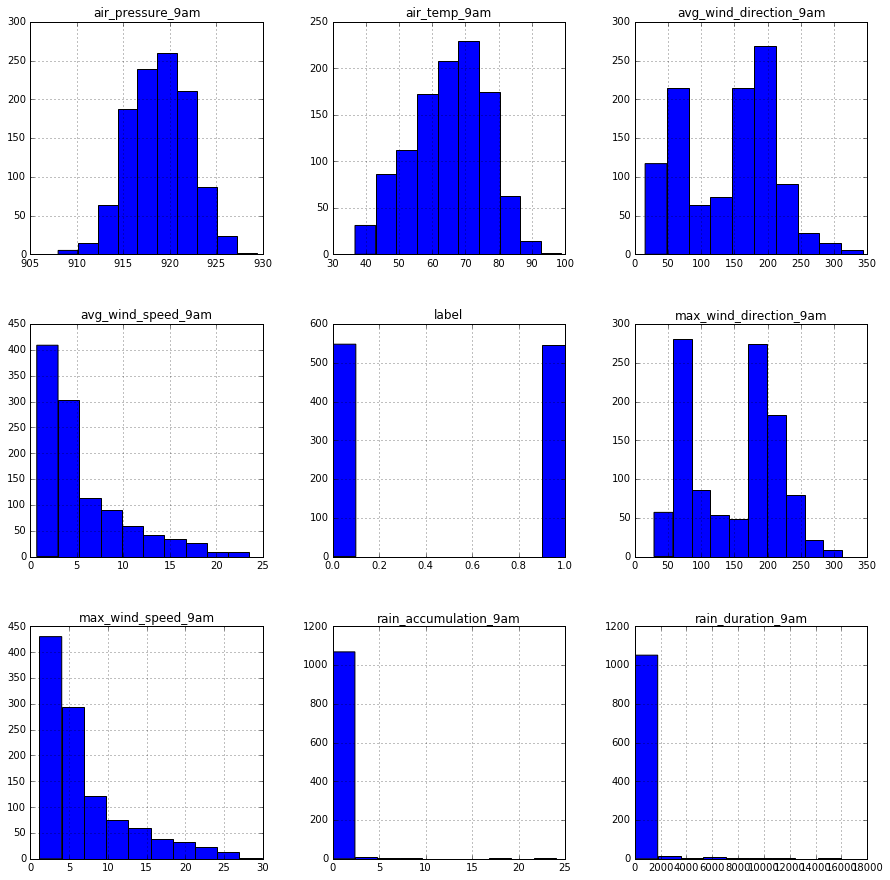

In [40]:
z=f.hist(figsize=(15,15))

# Scatter plot

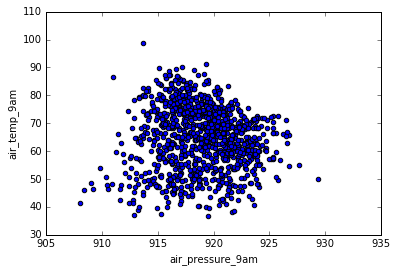

In [41]:
z=f.plot.scatter(x='air_pressure_9am', y='air_temp_9am')

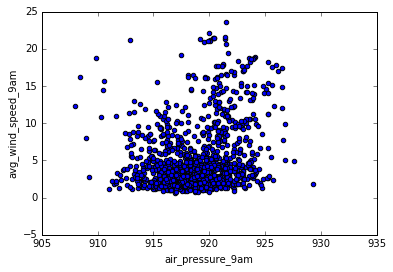

In [42]:
z=f.plot.scatter(x='air_pressure_9am', y='avg_wind_speed_9am')

# Bar Plot

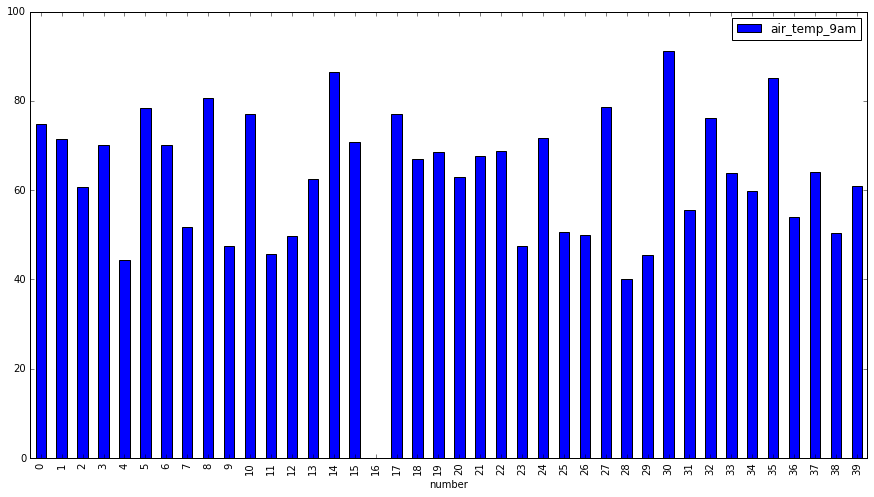

In [43]:
what = ['air_temp_9am']
z=f[what].head(40).plot(kind = 'bar', figsize=(15,8))

# Box Plot

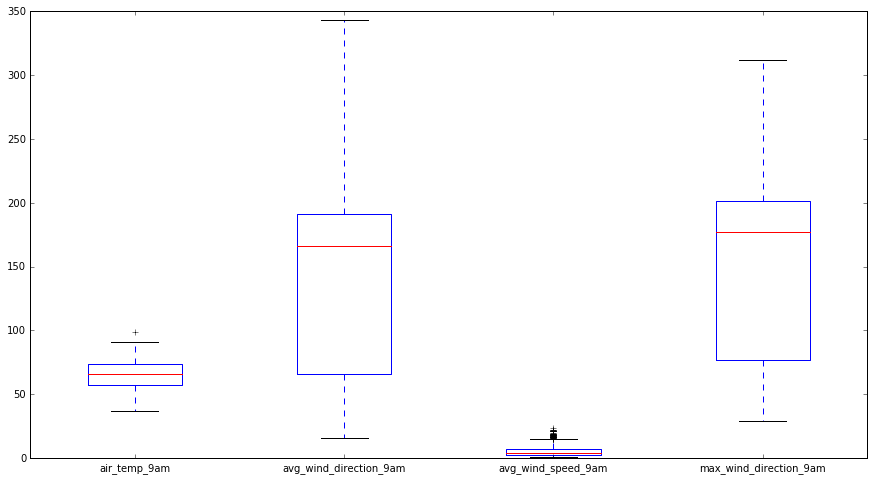

In [44]:
what = ['air_temp_9am','avg_wind_direction_9am','avg_wind_speed_9am','max_wind_direction_9am']
z=f[what].plot(kind = 'box', figsize=(15,8))

In [45]:
#from pyspark.mllib.linalg import DenseVector 
cols = ['air_pressure_9am','air_temp_9am','avg_wind_direction_9am','avg_wind_speed_9am','max_wind_direction_9am','max_wind_speed_9am','rain_accumulation_9am','rain_duration_9am']

In [46]:
from pyspark.ml.classification import DecisionTreeClassifier

# Hands on 2: Data Preparation

## Handling Missing Values

In [47]:
f.describe().head(3)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,label
count,1092.000000,1090.000000,1091.000000,1092.000000,1092.000000,1091.000000,1089.000000,1092.000000,1095.000000
mean,918.882551,64.933001,142.235511,5.508284,148.953518,7.019514,0.203079,294.108052,0.499543
std,3.184161,11.175514,69.137859,4.552813,67.238013,5.598209,1.593952,1598.078779,0.500228


## Missing Values: Remove them

In [48]:
e = f.dropna()

In [49]:
s = f.fillna(f.mean())

In [50]:
#Compare the Summary Statistics
e.describe().head(3)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,label
count,1064.00000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,918.90318,65.022609,142.306756,5.485793,148.480424,6.999714,0.182023,266.393697,0.497180
std,3.17904,11.168033,69.149472,4.534427,67.154911,5.590790,1.534493,1503.092216,0.500227


## Missing values : Replace with Mean

In [51]:
s = f.fillna(f.mean())

# OR replace with Median
#s = f.fillna(f.median()) 

In [52]:
#Compare the Summary Statistics
s.describe().head(3)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,label
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,918.882551,64.933001,142.235511,5.508284,148.953518,7.019514,0.203079,294.108052,0.499543
std,3.179792,11.149947,69.011349,4.546567,67.145759,5.587965,1.589575,1595.886124,0.500228


# Hands On 3: Classification

In [53]:
sqlContext = SQLContext(sc)
dataDF = sqlContext.createDataFrame(f.dropna())
dataDF.take(2)

[Row(air_pressure_9am=918.0600000000087, air_temp_9am=74.82200000000041, avg_wind_direction_9am=271.1, avg_wind_speed_9am=2.080354199999768, max_wind_direction_9am=295.3999999999998, max_wind_speed_9am=2.863283199999908, rain_accumulation_9am=0.0, rain_duration_9am=0.0, label=1),
 Row(air_pressure_9am=917.3476881177097, air_temp_9am=71.40384263106537, avg_wind_direction_9am=101.93517935618372, avg_wind_speed_9am=2.4430092157340217, max_wind_direction_9am=140.471548471125, max_wind_speed_9am=3.533323601610624, rain_accumulation_9am=0.0, rain_duration_9am=0.0, label=0)]

## Features Column

In [54]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer
assembler = VectorAssembler(inputCols=cols, outputCol="features")
assembled = assembler.transform(dataDF)
assembled

DataFrame[air_pressure_9am: double, air_temp_9am: double, avg_wind_direction_9am: double, avg_wind_speed_9am: double, max_wind_direction_9am: double, max_wind_speed_9am: double, rain_accumulation_9am: double, rain_duration_9am: double, label: bigint, features: vector]

In [55]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(assembled)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer= VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(assembled)

## Test and Training Data

In [56]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = assembled.randomSplit([0.7, 0.3], seed = 1234)

## Decision Tree in Spark

In [57]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",
                  maxDepth=5, maxBins=32, minInstancesPerNode=20, minInfoGain=0.0,
                  maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10,
                  impurity="gini")
    
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)
predictions.select("prediction", "indexedLabel", "features").show(5)


+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|[907.990000000002...|
|       1.0|         1.0|[908.420000000007...|
|       1.0|         1.0|[908.970000000004...|
|       1.0|         1.0|[913.060000000003...|
|       1.0|         0.0|[913.633267677041...|
+----------+------------+--------------------+
only showing top 5 rows



# Hands On 4: Evaluation of Machine Learning Models

## Accuracy - Decision Tree

In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")

accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))

Accuracy = 0.801325 


## Confusion Matrix - Decision Tree

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predictions.select('label').toPandas(), predictions.select('prediction').toPandas())

array([[ 32, 120],
       [122,  28]])

# Optional: 

## Naive Bayes in Spark

In [35]:
#Naive Bayes
from pyspark.ml.classification import NaiveBayes 
dtnb = NaiveBayes(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dtnb])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)
predictions.select("prediction", "indexedLabel", "features").show(5)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|[907.990000000002...|
|       1.0|         1.0|[908.420000000007...|
|       1.0|         1.0|[908.970000000004...|
|       0.0|         1.0|[913.060000000003...|
|       0.0|         0.0|[913.633267677041...|
+----------+------------+--------------------+
only showing top 5 rows



## Accuracy - Naive Bayes

In [36]:
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))

Accuracy = 0.569536 


## Confusion Matrix - Naive Bayes

In [37]:
confusion_matrix(predictions.select('label').toPandas(), predictions.select('prediction').toPandas())

array([[128,  24],
       [148,   2]])